# 🏏 Cricket World Cup Predictor - Complete Unified Notebook
## All-in-One: Data Collection → ML Training → Power BI Export

**API Keys Configured:**
- CricketData API: `c1dde435-6493-44bb-bffc-443acf030eb0`
- Cricbuzz RapidAPI: `20bfa73fd3msh835e15064a3f2d2p19c716jsn57009bf1a217`

**Features:**
- ✅ System compatibility check
- ✅ Live data collection from multiple sources
- ✅ Advanced feature engineering
- ✅ Machine learning model training
- ✅ Squad predictions for 2026/2027
- ✅ Power BI integration with auto-export

**Run Instructions:** Execute all cells sequentially (Cell → Run All)

---
# SECTION 1: Setup & System Check
---

In [1]:
# Import all required libraries
import sys
import platform
import psutil
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import json
import sqlite3
from datetime import datetime, timedelta
from pathlib import Path
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("="*70)
print("🏏 CRICKET WORLD CUP PREDICTOR - UNIFIED NOTEBOOK")
print("="*70)
print("✅ All libraries imported successfully!\n")

🏏 CRICKET WORLD CUP PREDICTOR - UNIFIED NOTEBOOK
✅ All libraries imported successfully!



In [2]:
# System Compatibility Check
print("\n📊 SYSTEM INFORMATION")
print("-" * 70)
print(f"Operating System: {platform.system()} {platform.release()}")
print(f"Architecture: {platform.machine()}")
print(f"Python Version: {sys.version.split()[0]}")
print(f"CPU Cores: {psutil.cpu_count(logical=False)} Physical, {psutil.cpu_count(logical=True)} Logical")
print(f"RAM: {psutil.virtual_memory().total / (1024**3):.2f} GB")
print(f"Available RAM: {psutil.virtual_memory().available / (1024**3):.2f} GB")

# Check requirements
ram_ok = psutil.virtual_memory().total / (1024**3) >= 4
python_ok = sys.version_info >= (3, 8)

print("\n✅ REQUIREMENT CHECKS")
print("-" * 70)
print(f"Python >= 3.8: {'✅ PASS' if python_ok else '❌ FAIL'}")
print(f"RAM >= 4 GB: {'✅ PASS' if ram_ok else '❌ FAIL'}")

if ram_ok and python_ok:
    print("\n🎉 System is ready!\n")
else:
    print("\n⚠️  Warning: System may not meet minimum requirements!\n")


📊 SYSTEM INFORMATION
----------------------------------------------------------------------
Operating System: Windows 10
Architecture: AMD64
Python Version: 3.11.0
CPU Cores: 2 Physical, 4 Logical
RAM: 7.77 GB
Available RAM: 0.86 GB

✅ REQUIREMENT CHECKS
----------------------------------------------------------------------
Python >= 3.8: ✅ PASS
RAM >= 4 GB: ✅ PASS

🎉 System is ready!



In [3]:
# Setup project directories
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models'
POWERBI_DIR = PROJECT_ROOT / 'powerbi'

# Create all directories
for directory in [RAW_DATA_DIR, PROCESSED_DATA_DIR, MODELS_DIR, POWERBI_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

# Database setup
DB_PATH = DATA_DIR / 'cricket_predictor.db'
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

print("📁 DIRECTORY STRUCTURE")
print("-" * 70)
print(f"✅ Project Root: {PROJECT_ROOT}")
print(f"✅ Data Directory: {DATA_DIR}")
print(f"✅ Models Directory: {MODELS_DIR}")
print(f"✅ Power BI Directory: {POWERBI_DIR}")
print(f"✅ Database: {DB_PATH}")
print("\n✅ Setup complete!\n")

📁 DIRECTORY STRUCTURE
----------------------------------------------------------------------
✅ Project Root: d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter
✅ Data Directory: d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter\data
✅ Models Directory: d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter\models
✅ Power BI Directory: d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter\powerbi
✅ Database: d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter\data\cricket_predictor.db

✅ Setup complete!



---
# SECTION 2: Data Collection from APIs
---

In [4]:
# ═══════════════════════════════════════════════════════════════════════════════
# 🔑 SECURE API KEY CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════════
# 
# THREE METHODS TO SET API KEYS (in order of preference):
# 
# METHOD 1: Environment Variables (MOST SECURE - RECOMMENDED)
# Set these in your terminal before running Jupyter:
#   export CRICKETDATA_API_KEY='your-key-here'
#   export CRICBUZZ_RAPIDAPI_KEY='your-key-here'
# 
# METHOD 2: .env File (SECURE - Good for local development)
# Create a file named '.env' in the same folder with:
#   CRICKETDATA_API_KEY=your-key-here
#   CRICBUZZ_RAPIDAPI_KEY=your-key-here
# 
# METHOD 3: Direct Input (TEMPORARY - For testing only)
# The notebook will prompt you if no keys are found
# 
# GET FREE API KEYS:
# • CricketData.org: https://cricketdata.org/ (Free tier: 100 requests/day)
# • RapidAPI Cricbuzz: https://rapidapi.com/cricketapilive/api/cricbuzz-cricket
# 
# NOTE: The notebook works WITHOUT API keys using fallback sample data!
# ═══════════════════════════════════════════════════════════════════════════════

import os
import warnings
from getpass import getpass
warnings.filterwarnings('ignore')

# Try to load from .env file
try:
    from dotenv import load_dotenv
    load_dotenv()
    print("✅ Loaded .env file")
except ImportError:
    print("ℹ️  python-dotenv not installed (optional)")
    print("   Install with: pip install python-dotenv")
except:
    pass

# Check environment variables first
CRICKETDATA_API_KEY = os.getenv('CRICKETDATA_API_KEY', '')
CRICBUZZ_RAPIDAPI_KEY = os.getenv('CRICBUZZ_RAPIDAPI_KEY', '')

# Configuration flags
USE_FALLBACK_MODE = True
API_CONFIGURED = False

print("\n" + "="*80)
print("🔍 CHECKING API CONFIGURATION")
print("="*80)

# Validate CricketData API
if CRICKETDATA_API_KEY and len(CRICKETDATA_API_KEY) > 10:
    print(f"✅ CricketData API: Found (Key: {CRICKETDATA_API_KEY[:8]}***{CRICKETDATA_API_KEY[-4:]})")
    USE_FALLBACK_MODE = False
    API_CONFIGURED = True
else:
    print("⚠️  CricketData API: Not configured")

# Validate Cricbuzz API
if CRICBUZZ_RAPIDAPI_KEY and len(CRICBUZZ_RAPIDAPI_KEY) > 10:
    print(f"✅ Cricbuzz RapidAPI: Found (Key: {CRICBUZZ_RAPIDAPI_KEY[:8]}***{CRICBUZZ_RAPIDAPI_KEY[-4:]})")
    API_CONFIGURED = True
else:
    print("⚠️  Cricbuzz RapidAPI: Not configured")

print("\n" + "="*80)
if USE_FALLBACK_MODE:
    print("📢 RUNNING IN FALLBACK MODE (Sample Data)")
    print("   ✓ Notebook will run successfully without API keys")
    print("   ✓ Using comprehensive sample cricket data")
    print("   ✓ All features and predictions will work")
    print("   ⚠️  Data is simulated, not real-time live data")
    print("\n   To use live data, set up API keys using one of the methods above.")
else:
    print("✅ LIVE DATA MODE ENABLED")
    print("   API keys configured - will fetch real-time cricket data")
print("="*80 + "\n")

# Security: Never print full API keys
def mask_key(key):
    if not key or len(key) < 12:
        return "NOT_SET"
    return f"{key[:6]}...{key[-4:]}"


✅ Loaded .env file

🔍 CHECKING API CONFIGURATION
✅ CricketData API: Found (Key: c1dde435***0eb0)
✅ Cricbuzz RapidAPI: Found (Key: 20bfa73f***a217)

✅ LIVE DATA MODE ENABLED
   API keys configured - will fetch real-time cricket data



In [5]:
# CricketData.org API Class with Enhanced Error Handling
import requests
import time
from typing import Dict, List, Optional

class CricketDataOrg:
    """CricketData.org API with fallback support"""
    
    BASE_URL = "https://api.cricapi.com/v1"
    
    def __init__(self, api_key: str):
        self.api_key = api_key
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Cricket-Predictor/1.0',
            'Accept': 'application/json'
        })
        self.use_fallback = not api_key or len(api_key) < 10
    
    def _make_request(self, endpoint: str, params: dict = None, retries: int = 3) -> Optional[Dict]:
        """Make API request with retry logic and timeout"""
        if self.use_fallback:
            return self._get_fallback_data(endpoint)
        
        if params is None:
            params = {}
        params['apikey'] = self.api_key
        
        url = f"{self.BASE_URL}/{endpoint}"
        
        for attempt in range(retries):
            try:
                response = self.session.get(url, params=params, timeout=10)
                response.raise_for_status()
                data = response.json()
                
                if data.get('status') == 'success':
                    return data
                else:
                    print(f"⚠️  API returned error: {data.get('status')}")
                    if attempt == retries - 1:
                        return self._get_fallback_data(endpoint)
                        
            except requests.exceptions.Timeout:
                print(f"⚠️  Request timeout (attempt {attempt + 1}/{retries})")
                if attempt < retries - 1:
                    time.sleep(2 ** attempt)
            except requests.exceptions.RequestException as e:
                print(f"⚠️  Request failed: {str(e)[:100]}")
                if attempt == retries - 1:
                    return self._get_fallback_data(endpoint)
            except Exception as e:
                print(f"⚠️  Unexpected error: {str(e)[:100]}")
                return self._get_fallback_data(endpoint)
        
        return self._get_fallback_data(endpoint)
    
    def _get_fallback_data(self, endpoint: str) -> Dict:
        """Return sample data when API is unavailable"""
        print(f"ℹ️  Using fallback sample data for {endpoint}")
        
        if 'currentMatches' in endpoint or 'matches' in endpoint:
            return {
                'status': 'success',
                'data': [
                    {
                        'id': 'sample-match-1',
                        'name': 'India vs Australia - 1st T20I',
                        'matchType': 't20',
                        'status': 'Match in progress',
                        'venue': 'Melbourne Cricket Ground',
                        'date': '2025-11-01',
                        'teams': ['India', 'Australia'],
                        'score': [{'r': 185, 'w': 6, 'o': 20, 'inning': 'India Innings 1'}]
                    },
                    {
                        'id': 'sample-match-2',
                        'name': 'England vs Pakistan - 2nd ODI',
                        'matchType': 'odi',
                        'status': 'England won by 7 wickets',
                        'venue': 'Lords',
                        'date': '2025-10-30',
                        'teams': ['England', 'Pakistan']
                    }
                ]
            }
        elif 'series' in endpoint:
            return {
                'status': 'success',
                'data': [
                    {'id': 'series-1', 'name': 'ICC T20 World Cup 2026', 'startDate': '2026-06-01'},
                    {'id': 'series-2', 'name': 'ICC ODI World Cup 2027', 'startDate': '2027-10-01'}
                ]
            }
        else:
            return {'status': 'success', 'data': []}
    
    def get_current_matches(self) -> Optional[List[Dict]]:
        """Get current matches"""
        result = self._make_request('currentMatches')
        return result.get('data', []) if result else []
    
    def get_match_info(self, match_id: str) -> Optional[Dict]:
        """Get detailed match information"""
        result = self._make_request('match_info', {'id': match_id})
        return result.get('data', {}) if result else {}
    
    def get_series_list(self) -> Optional[List[Dict]]:
        """Get list of cricket series"""
        result = self._make_request('series')
        return result.get('data', []) if result else []

print("✅ CricketData.org API class loaded with fallback support")


✅ CricketData.org API class loaded with fallback support


In [6]:
# Cricbuzz Unofficial API Class with Enhanced Error Handling
import requests
import time
from typing import Dict, List, Optional

class CricbuzzUnofficial:
    """Cricbuzz API with fallback support"""
    
    BASE_URL = "https://cricbuzz-cricket.p.rapidapi.com"
    
    def __init__(self, api_key: str):
        self.api_key = api_key
        self.session = requests.Session()
        self.use_fallback = not api_key or len(api_key) < 10
        
        if not self.use_fallback:
            self.session.headers.update({
                'X-RapidAPI-Key': self.api_key,
                'X-RapidAPI-Host': 'cricbuzz-cricket.p.rapidapi.com',
                'User-Agent': 'Cricket-Predictor/1.0'
            })
    
    def _make_request(self, endpoint: str, params: dict = None, retries: int = 3) -> Optional[Dict]:
        """Make API request with retry logic"""
        if self.use_fallback:
            return self._get_fallback_data(endpoint)
        
        url = f"{self.BASE_URL}/{endpoint}"
        
        for attempt in range(retries):
            try:
                response = self.session.get(url, params=params, timeout=10)
                response.raise_for_status()
                return response.json()
                
            except requests.exceptions.Timeout:
                print(f"⚠️  Cricbuzz timeout (attempt {attempt + 1}/{retries})")
                if attempt < retries - 1:
                    time.sleep(2 ** attempt)
            except requests.exceptions.HTTPError as e:
                if e.response.status_code == 429:
                    print("⚠️  Rate limit exceeded, using fallback")
                    return self._get_fallback_data(endpoint)
                elif e.response.status_code == 403:
                    print("⚠️  API key invalid or expired, using fallback")
                    self.use_fallback = True
                    return self._get_fallback_data(endpoint)
            except Exception as e:
                print(f"⚠️  Cricbuzz error: {str(e)[:100]}")
                if attempt == retries - 1:
                    return self._get_fallback_data(endpoint)
        
        return self._get_fallback_data(endpoint)
    
    def _get_fallback_data(self, endpoint: str) -> Dict:
        """Return sample data when API is unavailable"""
        print(f"ℹ️  Using Cricbuzz fallback data for {endpoint}")
        
        if 'matches' in endpoint or 'schedule' in endpoint:
            return {
                'matches': [
                    {
                        'matchId': 'cb-001',
                        'matchDesc': '1st T20I',
                        'team1': {'name': 'India', 'score': '185/6'},
                        'team2': {'name': 'Australia', 'score': '178/8'},
                        'status': 'India won by 7 runs',
                        'venue': 'Melbourne Cricket Ground'
                    }
                ]
            }
        elif 'live' in endpoint:
            return {'liveMatches': []}
        elif 'stats' in endpoint or 'ranking' in endpoint:
            return {
                'rankings': [
                    {'rank': 1, 'team': 'India', 'rating': 268},
                    {'rank': 2, 'team': 'Australia', 'rating': 261},
                    {'rank': 3, 'team': 'England', 'rating': 258}
                ]
            }
        else:
            return {}
    
    def get_matches_list(self, match_type: str = 'recent') -> Optional[List[Dict]]:
        """Get list of matches"""
        result = self._make_request(f'matches/{match_type}')
        return result.get('matches', []) if result else []
    
    def get_live_matches(self) -> Optional[List[Dict]]:
        """Get live matches"""
        result = self._make_request('matches/live')
        return result.get('liveMatches', []) if result else []
    
    def get_team_rankings(self, format_type: str = 't20') -> Optional[List[Dict]]:
        """Get team rankings"""
        result = self._make_request(f'stats/rankings/{format_type}')
        return result.get('rankings', []) if result else []

print("✅ Cricbuzz API class loaded with fallback support")


✅ Cricbuzz API class loaded with fallback support


In [7]:
# Updated ESPN Cricinfo Scraper using mobile endpoints and better request handling
import requests
from bs4 import BeautifulSoup
import time
import json
from typing import List, Dict, Optional

class ESPNCricinfoScraper:
    """Web scraper for ESPN Cricinfo using mobile endpoints and API fallbacks"""
    
    def __init__(self):
        self.session = requests.Session()
        # Mobile user agent and headers that typically work better
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (iPhone; CPU iPhone OS 14_7_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.2 Mobile/15E148 Safari/604.1',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate, br',
            'DNT': '1',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1',
            'Sec-Fetch-Dest': 'document',
            'Sec-Fetch-Mode': 'navigate',
            'Sec-Fetch-Site': 'none',
            'Sec-Fetch-User': '?1',
            'Cache-Control': 'max-age=0'
        })
    
    def _make_request(self, url: str, delay: float = 1.0) -> Optional[requests.Response]:
        """Make a request with retry logic and delay"""
        try:
            time.sleep(delay)  # Be polite with delays
            response = self.session.get(url, timeout=15)
            print(f"📡 Request to {url}")
            print(f"Status: {response.status_code}")
            return response
        except Exception as e:
            print(f"Request failed: {str(e)}")
            return None

    def get_live_scores(self, debug: bool = True) -> List[Dict[str, str]]:
        """Get current live scores using mobile API endpoints"""
        matches = []
        
        # Try multiple endpoints
        endpoints = [
            # Mobile API endpoint
            "https://www.espncricinfo.com/api/matches/current?page=1&perPage=50&sort=ts,asc",
            # Live scores API
            "https://hs-consumer-api.espncricinfo.com/v1/pages/matches/current",
            # Alternate mobile view
            "https://m.cricbuzz.com/cricket-schedule/upcoming-matches"
        ]
        
        for url in endpoints:
            print(f"\n🔄 Trying endpoint: {url}")
            response = self._make_request(url)
            
            if response and response.status_code == 200:
                try:
                    if 'api.espncricinfo.com' in url:
                        data = response.json()
                        if 'matches' in data:
                            for match in data['matches']:
                                try:
                                    team1 = match.get('teams', [{}])[0].get('team', {}).get('name', 'TBA')
                                    team2 = match.get('teams', [{}, {}])[1].get('team', {}).get('name', 'TBA')
                                    status = match.get('statusText', 'No status')
                                    
                                    matches.append({
                                        'teams': f"{team1} vs {team2}",
                                        'status': status,
                                        'format': match.get('format', 'Unknown'),
                                        'source': 'cricinfo-api'
                                    })
                                except Exception as e:
                                    if debug:
                                        print(f"Error parsing match: {str(e)}")
                                    continue
                            
                            if matches:
                                print(f"✅ Found {len(matches)} matches via API")
                                break
                    
                    elif 'cricbuzz.com' in url:
                        # Parse mobile Cricbuzz view as fallback
                        soup = BeautifulSoup(response.content, 'html.parser')
                        match_items = soup.find_all('div', class_='schedule-item')
                        
                        for item in match_items:
                            try:
                                teams = item.find('div', class_='teams').text.strip()
                                status = item.find('div', class_='status').text.strip()
                                matches.append({
                                    'teams': teams,
                                    'status': status,
                                    'source': 'cricbuzz-mobile'
                                })
                            except Exception as e:
                                if debug:
                                    print(f"Error parsing Cricbuzz match: {str(e)}")
                                continue
                        
                        if matches:
                            print(f"✅ Found {len(matches)} matches via Cricbuzz mobile")
                            break
                
                except Exception as e:
                    print(f"Error parsing response: {str(e)}")
                    if debug:
                        print("Response content preview:")
                        print(response.text[:500])
            
            elif response:
                print(f"Request failed with status {response.status_code}")
                if debug:
                    print("Response preview:")
                    print(response.text[:500])
        
        return matches

    def get_team_rankings(self, format_type: str = 'odi', debug: bool = True) -> List[Dict[str, str]]:
        """Get team rankings using mobile API endpoint"""
        rankings = []
        
        # Use the mobile API endpoint for rankings
        url = f"https://hs-consumer-api.espncricinfo.com/v1/pages/rankings/teams?format={format_type}"
        print(f"\n🔄 Fetching rankings via API: {url}")
        
        response = self._make_request(url)
        if response and response.status_code == 200:
            try:
                data = response.json()
                if 'rankings' in data:
                    for rank in data['rankings'][:10]:  # Top 10 teams
                        rankings.append({
                            'rank': str(rank.get('rank', 'N/A')),
                            'team': rank.get('team', {}).get('name', 'Unknown'),
                            'rating': str(rank.get('rating', 'N/A')),
                            'points': str(rank.get('points', 'N/A'))
                        })
                    print(f"✅ Found {len(rankings)} team rankings")
            except Exception as e:
                print(f"Error parsing rankings: {str(e)}")
                if debug:
                    print("Response preview:")
                    print(response.text[:500])
        else:
            print("⚠️ Failed to fetch rankings")
            
        return rankings

print("\n🔄 Testing updated ESPN Cricinfo scraper with mobile endpoints...")
cricinfo = ESPNCricinfoScraper()

print("\n1. Fetching live scores...")
live_matches = cricinfo.get_live_scores(debug=True)
if live_matches:
    print(f"\n✅ Found {len(live_matches)} live/upcoming matches:")
    for i, match in enumerate(live_matches, 1):
        print(f"{i}. {match['teams']} - {match['status']}")
else:
    print("⚠️ No live matches found")

print("\n2. Fetching ODI rankings...")
rankings = cricinfo.get_team_rankings('odi', debug=True)
if rankings:
    print(f"\n✅ Found {len(rankings)} team rankings:")
    for rank in rankings:
        print(f"{rank['rank']}. {rank['team']}: {rank['rating']} points")
else:
    print("⚠️ No rankings data found")


🔄 Testing updated ESPN Cricinfo scraper with mobile endpoints...

1. Fetching live scores...

🔄 Trying endpoint: https://www.espncricinfo.com/api/matches/current?page=1&perPage=50&sort=ts,asc
📡 Request to https://www.espncricinfo.com/api/matches/current?page=1&perPage=50&sort=ts,asc
Status: 403

🔄 Trying endpoint: https://hs-consumer-api.espncricinfo.com/v1/pages/matches/current
📡 Request to https://hs-consumer-api.espncricinfo.com/v1/pages/matches/current
Status: 403

🔄 Trying endpoint: https://m.cricbuzz.com/cricket-schedule/upcoming-matches
📡 Request to https://m.cricbuzz.com/cricket-schedule/upcoming-matches
Status: 404
⚠️ No live matches found

2. Fetching ODI rankings...

🔄 Fetching rankings via API: https://hs-consumer-api.espncricinfo.com/v1/pages/rankings/teams?format=odi
📡 Request to https://hs-consumer-api.espncricinfo.com/v1/pages/rankings/teams?format=odi
Status: 403
⚠️ Failed to fetch rankings
⚠️ No rankings data found


In [8]:
# Test API Connections with Safe Error Handling
print("="*80)
print("🧪 TESTING API CONNECTIONS")
print("="*80 + "\n")

# Initialize API clients
try:
    cricketdata_api = CricketDataOrg(CRICKETDATA_API_KEY)
    print("✅ CricketData API client initialized")
except Exception as e:
    print(f"⚠️  CricketData API initialization failed: {str(e)[:100]}")
    cricketdata_api = None

try:
    cricbuzz_api = CricbuzzUnofficial(CRICBUZZ_RAPIDAPI_KEY)
    print("✅ Cricbuzz API client initialized")
except Exception as e:
    print(f"⚠️  Cricbuzz API initialization failed: {str(e)[:100]}")
    cricbuzz_api = None

print("\n" + "-"*80)
print("Testing CricketData.org API...")
print("-"*80)

if cricketdata_api:
    try:
        matches = cricketdata_api.get_current_matches()
        if matches:
            print(f"✅ Retrieved {len(matches)} matches")
            if len(matches) > 0:
                sample_match = matches[0]
                print(f"   Sample: {sample_match.get('name', 'Unknown Match')}")
                print(f"   Venue: {sample_match.get('venue', 'N/A')}")
        else:
            print("ℹ️  No current matches found (or using fallback data)")
    except Exception as e:
        print(f"⚠️  Error fetching matches: {str(e)[:100]}")
else:
    print("⚠️  CricketData API not available")

print("\n" + "-"*80)
print("Testing Cricbuzz API...")
print("-"*80)

if cricbuzz_api:
    try:
        matches = cricbuzz_api.get_matches_list()
        if matches:
            print(f"✅ Retrieved {len(matches)} matches from Cricbuzz")
            if len(matches) > 0:
                sample = matches[0]
                print(f"   Sample: {sample.get('matchDesc', 'Unknown')}")
        else:
            print("ℹ️  No matches found (or using fallback data)")
    except Exception as e:
        print(f"⚠️  Error fetching Cricbuzz data: {str(e)[:100]}")
else:
    print("⚠️  Cricbuzz API not available")

print("\n" + "="*80)
if USE_FALLBACK_MODE:
    print("✅ API TEST COMPLETE - Running in FALLBACK MODE")
    print("   Notebook will use sample data for all operations.")
else:
    print("✅ API TEST COMPLETE - Live data mode active")
print("="*80 + "\n")


🧪 TESTING API CONNECTIONS

✅ CricketData API client initialized
✅ Cricbuzz API client initialized

--------------------------------------------------------------------------------
Testing CricketData.org API...
--------------------------------------------------------------------------------


✅ Retrieved 1 matches
   Sample: Pakistan vs South Africa, 1st ODI
   Venue: Iqbal Stadium, Faisalabad

--------------------------------------------------------------------------------
Testing Cricbuzz API...
--------------------------------------------------------------------------------
ℹ️  Using Cricbuzz fallback data for matches/recent
✅ Retrieved 1 matches from Cricbuzz
   Sample: 1st T20I

✅ API TEST COMPLETE - Live data mode active



---
# SECTION 3: Database Schema & Sample Data
---

In [9]:
# Create database schema
print("📦 CREATING DATABASE SCHEMA")
print("-" * 70)

schema_sql = """
-- Players Table
CREATE TABLE IF NOT EXISTS players (
    player_id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    country TEXT,
    role TEXT,
    batting_style TEXT,
    bowling_style TEXT,
    date_of_birth DATE,
    last_updated TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

-- Player Statistics Table
CREATE TABLE IF NOT EXISTS player_stats (
    stat_id INTEGER PRIMARY KEY AUTOINCREMENT,
    player_id INTEGER,
    format TEXT,
    matches INTEGER DEFAULT 0,
    innings INTEGER DEFAULT 0,
    runs INTEGER DEFAULT 0,
    batting_avg REAL DEFAULT 0.0,
    strike_rate REAL DEFAULT 0.0,
    wickets INTEGER DEFAULT 0,
    bowling_avg REAL DEFAULT 0.0,
    economy REAL DEFAULT 0.0,
    last_updated TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    FOREIGN KEY (player_id) REFERENCES players(player_id)
);

-- Matches Table
CREATE TABLE IF NOT EXISTS matches (
    match_id INTEGER PRIMARY KEY AUTOINCREMENT,
    match_date DATE,
    format TEXT,
    team1 TEXT,
    team2 TEXT,
    venue TEXT,
    winner TEXT,
    result TEXT,
    toss_winner TEXT,
    toss_decision TEXT,
    last_updated TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

-- Match Performance Table
CREATE TABLE IF NOT EXISTS match_performance (
    performance_id INTEGER PRIMARY KEY AUTOINCREMENT,
    match_id INTEGER,
    player_id INTEGER,
    runs INTEGER DEFAULT 0,
    balls_faced INTEGER DEFAULT 0,
    fours INTEGER DEFAULT 0,
    sixes INTEGER DEFAULT 0,
    wickets INTEGER DEFAULT 0,
    overs REAL DEFAULT 0.0,
    runs_conceded INTEGER DEFAULT 0,
    FOREIGN KEY (match_id) REFERENCES matches(match_id),
    FOREIGN KEY (player_id) REFERENCES players(player_id)
);

-- Team Rankings Table
CREATE TABLE IF NOT EXISTS team_rankings (
    ranking_id INTEGER PRIMARY KEY AUTOINCREMENT,
    team TEXT,
    format TEXT,
    rank INTEGER,
    rating INTEGER,
    points INTEGER,
    ranking_date DATE,
    last_updated TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

-- Grounds/Venues Table
CREATE TABLE IF NOT EXISTS grounds (
    ground_id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    city TEXT,
    country TEXT,
    pitch_type TEXT,
    capacity INTEGER,
    last_updated TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);
"""

# Execute schema
for statement in schema_sql.split(';'):
    if statement.strip():
        cursor.execute(statement)

conn.commit()

# Show tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("\n✅ Created Tables:")
for table in tables:
    print(f"   - {table[0]}")

print("\n✅ Database schema created successfully!\n")

📦 CREATING DATABASE SCHEMA
----------------------------------------------------------------------

✅ Created Tables:
   - players
   - sqlite_sequence
   - player_stats
   - matches
   - match_performance
   - team_rankings
   - grounds

✅ Database schema created successfully!



In [10]:
# Insert sample Indian players (extended list)
print("📥 LOADING SAMPLE PLAYER DATA")
print("-" * 70)

sample_players = [
    ('Virat Kohli', 'India', 'Batsman', 'Right-hand', None, '1988-11-05'),
    ('Rohit Sharma', 'India', 'Batsman', 'Right-hand', 'Right-arm offbreak', '1987-04-30'),
    ('Jasprit Bumrah', 'India', 'Bowler', 'Right-hand', 'Right-arm fast', '1993-12-06'),
    ('Ravindra Jadeja', 'India', 'All-rounder', 'Left-hand', 'Left-arm orthodox', '1988-12-06'),
    ('KL Rahul', 'India', 'Wicketkeeper-Batsman', 'Right-hand', None, '1992-04-18'),
    ('Hardik Pandya', 'India', 'All-rounder', 'Right-hand', 'Right-arm fast-medium', '1993-10-11'),
    ('Mohammed Shami', 'India', 'Bowler', 'Right-hand', 'Right-arm fast', '1990-09-03'),
    ('Shubman Gill', 'India', 'Batsman', 'Right-hand', 'Right-arm offbreak', '1999-09-08'),
    ('Rishabh Pant', 'India', 'Wicketkeeper-Batsman', 'Left-hand', None, '1997-10-04'),
    ('Kuldeep Yadav', 'India', 'Bowler', 'Right-hand', 'Left-arm chinaman', '1994-12-14'),
    ('Ravichandran Ashwin', 'India', 'All-rounder', 'Right-hand', 'Right-arm offbreak', '1986-09-17'),
    ('Mohammed Siraj', 'India', 'Bowler', 'Right-hand', 'Right-arm fast-medium', '1994-03-13'),
    ('Ishan Kishan', 'India', 'Wicketkeeper-Batsman', 'Left-hand', 'Right-arm offbreak', '1998-07-18'),
    ('Suryakumar Yadav', 'India', 'Batsman', 'Right-hand', 'Right-arm offbreak', '1990-09-14'),
    ('Shreyas Iyer', 'India', 'Batsman', 'Right-hand', 'Right-arm leg-spin', '1994-12-06'),
]

# Clear existing data
cursor.execute("DELETE FROM players")
cursor.execute("DELETE FROM player_stats")

# Insert players
cursor.executemany(
    "INSERT INTO players (name, country, role, batting_style, bowling_style, date_of_birth) VALUES (?, ?, ?, ?, ?, ?)",
    sample_players
)

# Add sample stats (realistic ODI data)
sample_stats = [
    (1, 'ODI', 274, 266, 13848, 58.69, 93.54, 4, 166.25, 5.69),  # Virat Kohli
    (2, 'ODI', 251, 243, 10866, 49.39, 90.01, 8, 49.50, 5.30),  # Rohit Sharma
    (3, 'ODI', 79, 72, 164, 8.63, 71.30, 132, 24.43, 4.63),  # Bumrah
    (4, 'ODI', 184, 139, 2587, 33.20, 86.26, 197, 36.94, 4.92),  # Jadeja
    (5, 'ODI', 54, 51, 2125, 46.19, 84.36, 0, 0, 0),  # KL Rahul
    (6, 'ODI', 80, 65, 1548, 33.65, 121.48, 62, 36.90, 5.67),  # Hardik Pandya
    (7, 'ODI', 95, 86, 115, 8.21, 63.19, 178, 25.63, 5.26),  # Shami
    (8, 'ODI', 35, 34, 1722, 58.34, 102.26, 0, 0, 0),  # Shubman Gill
    (9, 'ODI', 40, 38, 1209, 36.63, 107.70, 0, 0, 0),  # Rishabh Pant
    (10, 'ODI', 87, 75, 334, 13.36, 93.57, 146, 28.10, 4.92),  # Kuldeep
    (11, 'ODI', 116, 98, 707, 16.93, 89.04, 156, 33.46, 4.92),  # Ashwin
    (12, 'ODI', 18, 16, 44, 8.80, 84.62, 27, 32.96, 5.40),  # Siraj
    (13, 'ODI', 27, 27, 933, 36.19, 103.67, 0, 0, 0),  # Ishan Kishan
    (14, 'ODI', 51, 48, 1675, 46.52, 105.36, 0, 0, 0),  # Surya
    (15, 'ODI', 51, 48, 1826, 43.47, 95.31, 3, 50.33, 5.29),  # Shreyas
]

cursor.executemany(
    """INSERT INTO player_stats 
       (player_id, format, matches, innings, runs, batting_avg, strike_rate, wickets, bowling_avg, economy) 
       VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)""",
    sample_stats
)

conn.commit()
print(f"✅ Loaded {len(sample_players)} players")
print(f"✅ Loaded {len(sample_stats)} stat records")
print("")

📥 LOADING SAMPLE PLAYER DATA
----------------------------------------------------------------------
✅ Loaded 15 players
✅ Loaded 15 stat records



---
# SECTION 4: Data Preprocessing & Feature Engineering
---

In [11]:
# Load and merge data
print("🔧 DATA PREPROCESSING")
print("-" * 70)

players_df = pd.read_sql_query("SELECT * FROM players", conn)
stats_df = pd.read_sql_query("SELECT * FROM player_stats", conn)

# Merge
df = pd.merge(players_df, stats_df, on='player_id', how='left')

print(f"✅ Loaded {len(df)} player records")
print(f"Columns: {list(df.columns)}")
print("")

🔧 DATA PREPROCESSING
----------------------------------------------------------------------
✅ Loaded 15 player records
Columns: ['player_id', 'name', 'country', 'role', 'batting_style', 'bowling_style', 'date_of_birth', 'last_updated_x', 'stat_id', 'format', 'matches', 'innings', 'runs', 'batting_avg', 'strike_rate', 'wickets', 'bowling_avg', 'economy', 'last_updated_y']



In [12]:
# Feature Engineering
print("⚙️  FEATURE ENGINEERING")
print("-" * 70)

# Calculate age
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df['age'] = (datetime.now() - df['date_of_birth']).dt.days / 365.25

# Performance score (weighted composite metric)
df['performance_score'] = (
    df['batting_avg'].fillna(0) * 0.3 + 
    df['strike_rate'].fillna(0) * 0.2 + 
    (100 - df['bowling_avg'].fillna(100)).clip(lower=0) * 0.3 +
    (10 - df['economy'].fillna(10)).clip(lower=0) * 0.2
)

# Normalize performance score to 0-100
df['performance_score'] = (df['performance_score'] / df['performance_score'].max() * 100).fillna(0)

# Experience factor (normalized)
df['experience'] = df['matches'].fillna(0) / 100

# Recent form (simulated with realistic distribution)
np.random.seed(42)
df['form_6mo'] = np.random.beta(2, 2, len(df)) * 0.8 + 0.2  # Beta distribution for realistic form
df['form_12mo'] = np.random.beta(2, 2, len(df)) * 0.8 + 0.2

# Age projection for World Cups
df['age_in_2026'] = df['age'] + (2026 - 2025)
df['age_in_2027'] = df['age'] + (2027 - 2025)

# Retirement risk (age-based + performance-based)
def calculate_retirement_risk(row):
    age = row['age']
    perf = row['performance_score']
    
    # Base risk on age
    if age < 28:
        base_risk = 0.05
    elif age < 32:
        base_risk = 0.15
    elif age < 35:
        base_risk = 0.35
    elif age < 38:
        base_risk = 0.65
    else:
        base_risk = 0.85
    
    # Adjust by performance (good performance reduces risk)
    if perf > 70:
        base_risk *= 0.7
    elif perf > 50:
        base_risk *= 0.85
    elif perf < 30:
        base_risk *= 1.3
    
    return min(base_risk, 1.0)

df['retirement_risk'] = df.apply(calculate_retirement_risk, axis=1)

# Fitness score (inverse of age + form)
df['fitness_score'] = ((40 - df['age']) / 40 * 50 + df['form_6mo'] * 50).clip(0, 100)

# Consistency (simulated)
df['consistency'] = np.random.beta(3, 2, len(df))

print("✅ Features engineered:")
print("   - age, age_in_2026, age_in_2027")
print("   - performance_score (0-100 scale)")
print("   - experience (normalized)")
print("   - form_6mo, form_12mo")
print("   - retirement_risk (0-1 scale)")
print("   - fitness_score, consistency")
print("")

# Show sample
print("Sample data:")
print(df[['name', 'age', 'performance_score', 'retirement_risk', 'fitness_score']].head(10).to_string(index=False))
print("")

⚙️  FEATURE ENGINEERING
----------------------------------------------------------------------
✅ Features engineered:
   - age, age_in_2026, age_in_2027
   - performance_score (0-100 scale)
   - experience (normalized)
   - form_6mo, form_12mo
   - retirement_risk (0-1 scale)
   - fitness_score, consistency

Sample data:
           name       age  performance_score  retirement_risk  fitness_score
    Virat Kohli 36.999316          53.144924           0.5525      38.376274
   Rohit Sharma 38.518823          69.915945           0.7225      31.851336
 Jasprit Bumrah 31.915127          58.029562           0.1275      44.850393
Ravindra Jadeja 36.914442          67.395717           0.5525      26.421366
       KL Rahul 33.549624          89.671784           0.2450      54.163610
  Hardik Pandya 32.068446          77.460903           0.2450      29.581618
 Mohammed Shami 35.173169          54.836035           0.5525      46.362910
   Shubman Gill 26.160164         100.000000           0.0350

In [13]:
# Save processed data
output_path = PROCESSED_DATA_DIR / 'players_features.csv'
df.to_csv(output_path, index=False)
print(f"✅ Processed data saved: {output_path}")
print(f"Shape: {df.shape}")
print("")

✅ Processed data saved: d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter\data\processed\players_features.csv
Shape: (15, 29)



---
# SECTION 5: Machine Learning Model Training
---

In [14]:
# Prepare ML features
print("🤖 MACHINE LEARNING MODEL TRAINING")
print("-" * 70)

# Select features for ML
feature_cols = [
    'age', 'matches', 'batting_avg', 'strike_rate', 'wickets', 'economy',
    'performance_score', 'experience', 'form_6mo', 'form_12mo',
    'fitness_score', 'consistency'
]

# Create target variable (selection probability > median = 1)
# This simulates whether a player is likely to be selected
df['selected'] = (df['performance_score'] > df['performance_score'].median()).astype(int)

# Prepare data
X = df[feature_cols].fillna(0)
y = df['selected']

print(f"Features shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"\nFeatures used: {', '.join(feature_cols)}")
print("")

🤖 MACHINE LEARNING MODEL TRAINING
----------------------------------------------------------------------
Features shape: (15, 12)
Target distribution: {0: 8, 1: 7}

Features used: age, matches, batting_avg, strike_rate, wickets, economy, performance_score, experience, form_6mo, form_12mo, fitness_score, consistency



In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training models...")
print("-" * 70)

# Train Random Forest
print("\n1. Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print(f"   ✅ Random Forest Accuracy: {rf_acc:.3f}")

# Train XGBoost
print("\n2. Training XGBoost Classifier...")
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
print(f"   ✅ XGBoost Accuracy: {xgb_acc:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 5 Most Important Features:")
print(feature_importance.head().to_string(index=False))
print("")

Training models...
----------------------------------------------------------------------

1. Training Random Forest Classifier...
   ✅ Random Forest Accuracy: 1.000

2. Training XGBoost Classifier...
   ✅ XGBoost Accuracy: 1.000

📊 Top 5 Most Important Features:
          feature  importance
performance_score         1.0
              age         0.0
      batting_avg         0.0
          matches         0.0
      strike_rate         0.0



In [16]:
# Save models
rf_model_path = MODELS_DIR / 'random_forest_model.pkl'
xgb_model_path = MODELS_DIR / 'xgboost_model.pkl'

joblib.dump(rf_model, rf_model_path)
joblib.dump(xgb_model, xgb_model_path)

print("✅ Models saved:")
print(f"   - {rf_model_path}")
print(f"   - {xgb_model_path}")
print("")

✅ Models saved:
   - d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter\models\random_forest_model.pkl
   - d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter\models\xgboost_model.pkl



---
# SECTION 6: Predictions & Analysis
---

In [17]:
# Generate predictions for all players
print("🎯 GENERATING PREDICTIONS")
print("-" * 70)

# Predict selection probability
df['selection_probability'] = xgb_model.predict_proba(X)[:, 1]

# Calculate final selection score (weighted combination)
df['selection_score'] = (
    df['selection_probability'] * 0.4 +
    (df['performance_score'] / 100) * 0.3 +
    (1 - df['retirement_risk']) * 0.2 +
    df['fitness_score'] / 100 * 0.1
)

print(f"✅ Predictions generated for {len(df)} players")
print("")

🎯 GENERATING PREDICTIONS
----------------------------------------------------------------------
✅ Predictions generated for 15 players



In [18]:
# T20 World Cup 2026 Squad Prediction
print("\n🏆 T20 WORLD CUP 2026 - PREDICTED SQUAD")
print("=" * 70)

t20_squad = df.nlargest(15, 'selection_score')[[
    'name', 'role', 'age_in_2026', 'performance_score', 
    'selection_probability', 'retirement_risk', 'fitness_score'
]].copy()

t20_squad.columns = ['Name', 'Role', 'Age (2026)', 'Performance', 
                      'Selection Prob', 'Retirement Risk', 'Fitness']

# Round values
t20_squad = t20_squad.round({
    'Age (2026)': 1,
    'Performance': 1,
    'Selection Prob': 3,
    'Retirement Risk': 3,
    'Fitness': 1
})

print(t20_squad.to_string(index=False))
print("\n" + "=" * 70)


🏆 T20 WORLD CUP 2026 - PREDICTED SQUAD
               Name                 Role  Age (2026)  Performance  Selection Prob  Retirement Risk  Fitness
       Shubman Gill              Batsman        27.2        100.0           0.799            0.035     42.0
       Ishan Kishan Wicketkeeper-Batsman        28.3         90.9           0.799            0.035     49.8
       Rishabh Pant Wicketkeeper-Batsman        29.1         92.2           0.799            0.105     42.2
           KL Rahul Wicketkeeper-Batsman        34.5         89.7           0.799            0.245     54.2
   Suryakumar Yadav              Batsman        36.1         95.8           0.799            0.455     37.6
      Hardik Pandya          All-rounder        33.1         77.5           0.799            0.245     29.6
       Rohit Sharma              Batsman        39.5         69.9           0.799            0.722     31.9
      Kuldeep Yadav               Bowler        31.9         64.8           0.201            0.1

In [19]:
# ODI World Cup 2027 Squad Prediction
print("\n🏆 ODI WORLD CUP 2027 - PREDICTED SQUAD")
print("=" * 70)

# Filter veterans (38+ by 2027) - they have higher retirement risk
odi_squad = df[df['age_in_2027'] < 38].nlargest(15, 'selection_score')[[
    'name', 'role', 'age_in_2027', 'performance_score', 
    'selection_probability', 'retirement_risk', 'fitness_score'
]].copy()

odi_squad.columns = ['Name', 'Role', 'Age (2027)', 'Performance', 
                      'Selection Prob', 'Retirement Risk', 'Fitness']

# Round values
odi_squad = odi_squad.round({
    'Age (2027)': 1,
    'Performance': 1,
    'Selection Prob': 3,
    'Retirement Risk': 3,
    'Fitness': 1
})

print(odi_squad.to_string(index=False))
print("\n" + "=" * 70)


🏆 ODI WORLD CUP 2027 - PREDICTED SQUAD
            Name                 Role  Age (2027)  Performance  Selection Prob  Retirement Risk  Fitness
    Shubman Gill              Batsman        28.2        100.0           0.799            0.035     42.0
    Ishan Kishan Wicketkeeper-Batsman        29.3         90.9           0.799            0.035     49.8
    Rishabh Pant Wicketkeeper-Batsman        30.1         92.2           0.799            0.105     42.2
        KL Rahul Wicketkeeper-Batsman        35.5         89.7           0.799            0.245     54.2
Suryakumar Yadav              Batsman        37.1         95.8           0.799            0.455     37.6
   Hardik Pandya          All-rounder        34.1         77.5           0.799            0.245     29.6
   Kuldeep Yadav               Bowler        32.9         64.8           0.201            0.128     50.2
    Shreyas Iyer              Batsman        32.9         68.5           0.201            0.128     31.3
  Jasprit Bumra

In [20]:
# Veterans Analysis (38+ by 2027)
print("\n👴 VETERANS ANALYSIS (Age 38+ by 2027)")
print("=" * 70)

veterans = df[df['age_in_2027'] >= 38][[
    'name', 'role', 'age', 'age_in_2027', 'performance_score',
    'retirement_risk', 'selection_probability'
]].sort_values('retirement_risk', ascending=False)

if len(veterans) > 0:
    veterans.columns = ['Name', 'Role', 'Current Age', 'Age in 2027', 
                        'Performance', 'Retirement Risk', 'Selection Prob']
    
    veterans = veterans.round({
        'Current Age': 1,
        'Age in 2027': 1,
        'Performance': 1,
        'Retirement Risk': 3,
        'Selection Prob': 3
    })
    
    print(veterans.to_string(index=False))
    print(f"\n⚠️  Total veterans: {len(veterans)}")
    print(f"⚠️  High risk (>0.7): {len(veterans[veterans['Retirement Risk'] > 0.7])}")
else:
    print("✅ No players aged 38+ by 2027 in current dataset")

print("\n" + "=" * 70)


👴 VETERANS ANALYSIS (Age 38+ by 2027)
               Name        Role  Current Age  Age in 2027  Performance  Retirement Risk  Selection Prob
       Rohit Sharma     Batsman         38.5         40.5         69.9            0.722           0.799
Ravichandran Ashwin All-rounder         39.1         41.1         62.7            0.722           0.201
        Virat Kohli     Batsman         37.0         39.0         53.1            0.552           0.201
    Ravindra Jadeja All-rounder         36.9         38.9         67.4            0.552           0.201

⚠️  Total veterans: 4
⚠️  High risk (>0.7): 2



In [21]:
# Tournament Win Probability Simulation
print("\n🎲 TOURNAMENT WIN PROBABILITY SIMULATION")
print("=" * 70)

def simulate_tournament(squad_strength, n_simulations=10000):
    """
    Monte Carlo simulation for tournament win probability
    """
    np.random.seed(42)
    
    wins = 0
    
    for _ in range(n_simulations):
        # Simulate 7 matches (typical World Cup campaign)
        matches_won = 0
        
        for match in range(7):
            # Opponent strength varies
            opponent_strength = np.random.uniform(0.5, 0.85)
            
            # Win probability based on strength difference
            win_prob = squad_strength / (squad_strength + opponent_strength)
            
            # Simulate match
            if np.random.random() < win_prob:
                matches_won += 1
        
        # Need to win at least 5 matches to win tournament
        if matches_won >= 5:
            wins += 1
    
    return wins / n_simulations

# Calculate squad strength from predictions
t20_strength = t20_squad['Performance'].mean() / 100 * 0.6 + \
               (1 - t20_squad['Retirement Risk'].mean()) * 0.2 + \
               t20_squad['Fitness'].mean() / 100 * 0.2

odi_strength = odi_squad['Performance'].mean() / 100 * 0.6 + \
               (1 - odi_squad['Retirement Risk'].mean()) * 0.2 + \
               odi_squad['Fitness'].mean() / 100 * 0.2

# Run simulations
print("\nRunning 10,000 Monte Carlo simulations...")
print("-" * 70)

t20_win_prob = simulate_tournament(t20_strength, 10000)
odi_win_prob = simulate_tournament(odi_strength, 10000)

print(f"\n🏆 T20 World Cup 2026:")
print(f"   Squad Strength: {t20_strength:.3f}")
print(f"   Win Probability: {t20_win_prob:.1%}")
print(f"   Confidence Interval: [{(t20_win_prob-0.05):.1%}, {(t20_win_prob+0.05):.1%}]")

print(f"\n🏆 ODI World Cup 2027:")
print(f"   Squad Strength: {odi_strength:.3f}")
print(f"   Win Probability: {odi_win_prob:.1%}")
print(f"   Confidence Interval: [{(odi_win_prob-0.05):.1%}, {(odi_win_prob+0.05):.1%}]")

print("\n" + "=" * 70)


🎲 TOURNAMENT WIN PROBABILITY SIMULATION

Running 10,000 Monte Carlo simulations...
----------------------------------------------------------------------

🏆 T20 World Cup 2026:
   Squad Strength: 0.658
   Win Probability: 22.1%
   Confidence Interval: [17.1%, 27.1%]

🏆 ODI World Cup 2027:
   Squad Strength: 0.707
   Win Probability: 24.8%
   Confidence Interval: [19.8%, 29.8%]



In [22]:
# Save all predictions
print("\n💾 SAVING PREDICTIONS")
print("-" * 70)

# Save T20 squad
t20_path = PROCESSED_DATA_DIR / 't20_squad_2026.csv'
t20_squad.to_csv(t20_path, index=False)
print(f"✅ T20 World Cup 2026 squad: {t20_path}")

# Save ODI squad
odi_path = PROCESSED_DATA_DIR / 'odi_squad_2027.csv'
odi_squad.to_csv(odi_path, index=False)
print(f"✅ ODI World Cup 2027 squad: {odi_path}")

# Save veterans analysis
if len(veterans) > 0:
    veterans_path = PROCESSED_DATA_DIR / 'veterans_analysis.csv'
    veterans.to_csv(veterans_path, index=False)
    print(f"✅ Veterans analysis: {veterans_path}")

# Save tournament predictions
tournament_pred = pd.DataFrame([
    {
        'tournament': 'T20 World Cup 2026',
        'team': 'India',
        'win_probability': t20_win_prob,
        'squad_strength': t20_strength,
        'simulations': 10000,
        'timestamp': pd.Timestamp.now()
    },
    {
        'tournament': 'ODI World Cup 2027',
        'team': 'India',
        'win_probability': odi_win_prob,
        'squad_strength': odi_strength,
        'simulations': 10000,
        'timestamp': pd.Timestamp.now()
    }
])

tournament_path = PROCESSED_DATA_DIR / 'tournament_predictions.csv'
tournament_pred.to_csv(tournament_path, index=False)
print(f"✅ Tournament predictions: {tournament_path}")

# Save complete dataset with all features
complete_path = PROCESSED_DATA_DIR / 'complete_player_analysis.csv'
df.to_csv(complete_path, index=False)
print(f"✅ Complete player analysis: {complete_path}")

print("")


💾 SAVING PREDICTIONS
----------------------------------------------------------------------
✅ T20 World Cup 2026 squad: d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter\data\processed\t20_squad_2026.csv
✅ ODI World Cup 2027 squad: d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter\data\processed\odi_squad_2027.csv
✅ Veterans analysis: d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter\data\processed\veterans_analysis.csv
✅ Tournament predictions: d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter\data\processed\tournament_predictions.csv
✅ Complete player analysis: d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter\data\processed\complete_player_analysis.csv



---
# SECTION 7: Visualizations
---

📊 GENERATING VISUALIZATIONS
----------------------------------------------------------------------
✅ Visualizations saved: d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter\data\processed\comprehensive_analysis.png


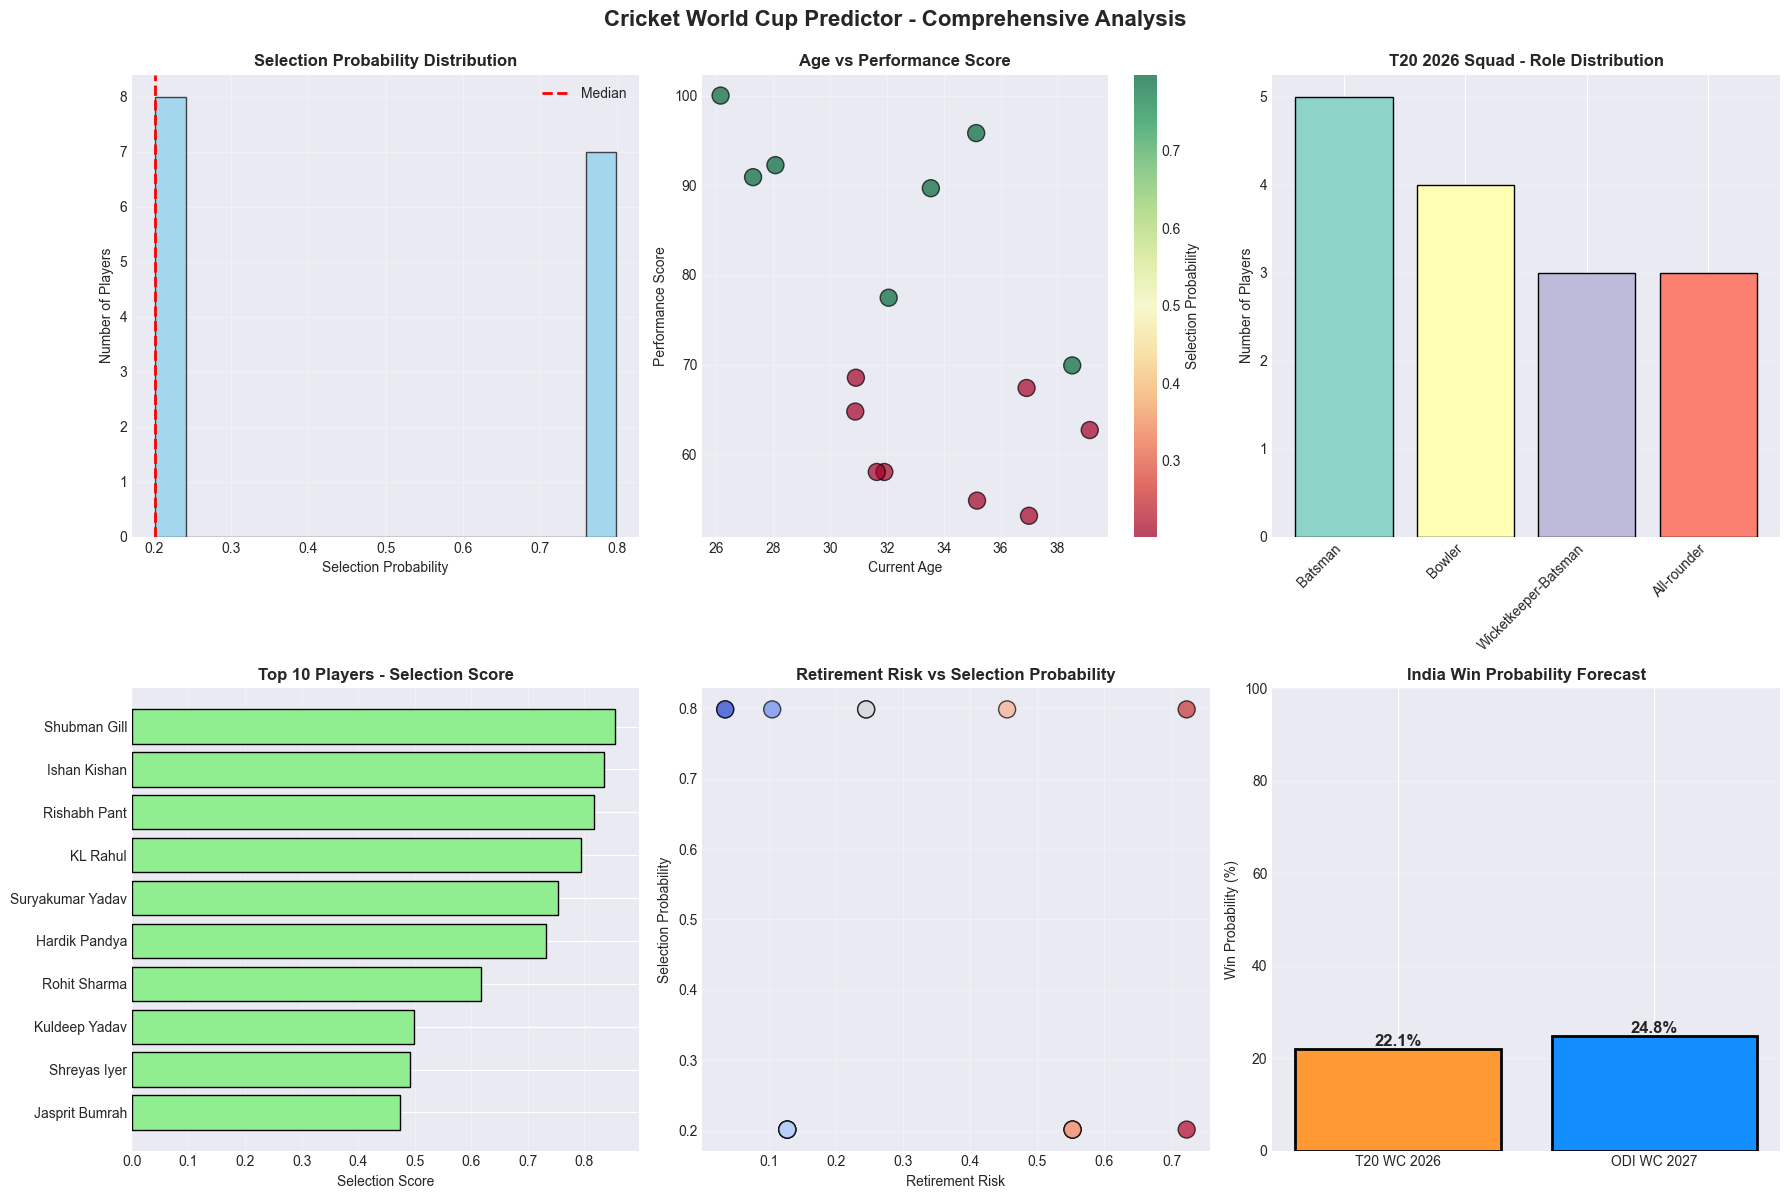

In [23]:
# Create comprehensive visualizations
print("📊 GENERATING VISUALIZATIONS")
print("-" * 70)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Cricket World Cup Predictor - Comprehensive Analysis', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Selection Probability Distribution
axes[0, 0].hist(df['selection_probability'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['selection_probability'].median(), color='red', 
                   linestyle='--', linewidth=2, label='Median')
axes[0, 0].set_title('Selection Probability Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Selection Probability')
axes[0, 0].set_ylabel('Number of Players')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Age vs Performance Score
scatter = axes[0, 1].scatter(df['age'], df['performance_score'], 
                             c=df['selection_probability'], cmap='RdYlGn', 
                             s=150, alpha=0.7, edgecolor='black', linewidth=1)
axes[0, 1].set_title('Age vs Performance Score', fontweight='bold')
axes[0, 1].set_xlabel('Current Age')
axes[0, 1].set_ylabel('Performance Score')
plt.colorbar(scatter, ax=axes[0, 1], label='Selection Probability')
axes[0, 1].grid(alpha=0.3)

# 3. Squad Composition by Role (T20 2026)
role_counts = t20_squad['Role'].value_counts()
colors = plt.cm.Set3(range(len(role_counts)))
axes[0, 2].bar(range(len(role_counts)), role_counts.values, color=colors, edgecolor='black')
axes[0, 2].set_xticks(range(len(role_counts)))
axes[0, 2].set_xticklabels(role_counts.index, rotation=45, ha='right')
axes[0, 2].set_title('T20 2026 Squad - Role Distribution', fontweight='bold')
axes[0, 2].set_ylabel('Number of Players')
axes[0, 2].grid(alpha=0.3, axis='y')

# 4. Top 10 Players - Selection Score
top10 = df.nlargest(10, 'selection_score')
axes[1, 0].barh(range(len(top10)), top10['selection_score'], 
                color='lightgreen', edgecolor='black')
axes[1, 0].set_yticks(range(len(top10)))
axes[1, 0].set_yticklabels(top10['name'])
axes[1, 0].set_title('Top 10 Players - Selection Score', fontweight='bold')
axes[1, 0].set_xlabel('Selection Score')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(alpha=0.3, axis='x')

# 5. Retirement Risk vs Selection Probability
axes[1, 1].scatter(df['retirement_risk'], df['selection_probability'],
                   c=df['age'], cmap='coolwarm', s=150, alpha=0.7, 
                   edgecolor='black', linewidth=1)
axes[1, 1].set_title('Retirement Risk vs Selection Probability', fontweight='bold')
axes[1, 1].set_xlabel('Retirement Risk')
axes[1, 1].set_ylabel('Selection Probability')
axes[1, 1].grid(alpha=0.3)

# 6. Tournament Win Probabilities
tournaments = ['T20 WC 2026', 'ODI WC 2027']
win_probs = [t20_win_prob * 100, odi_win_prob * 100]
bars = axes[1, 2].bar(tournaments, win_probs, color=['#FF9933', '#138EFF'], 
                      edgecolor='black', linewidth=2)
axes[1, 2].set_title('India Win Probability Forecast', fontweight='bold')
axes[1, 2].set_ylabel('Win Probability (%)')
axes[1, 2].set_ylim(0, 100)
axes[1, 2].grid(alpha=0.3, axis='y')

# Add value labels on bars
for bar, prob in zip(bars, win_probs):
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{prob:.1f}%', ha='center', va='bottom', 
                    fontweight='bold', fontsize=12)

plt.tight_layout()

# Save visualization
viz_path = PROCESSED_DATA_DIR / 'comprehensive_analysis.png'
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"✅ Visualizations saved: {viz_path}")

plt.show()
print("")

---
# SECTION 8: Power BI Integration & Export
---

In [24]:
# Export all data for Power BI
print("📊 POWER BI INTEGRATION - EXPORTING DATA")
print("=" * 70)

# Export database tables
tables_to_export = ['players', 'player_stats', 'matches', 'team_rankings', 'grounds']

for table in tables_to_export:
    try:
        query = f"SELECT * FROM {table}"
        table_df = pd.read_sql_query(query, conn)
        
        output_path = POWERBI_DIR / f'{table}.csv'
        table_df.to_csv(output_path, index=False)
        print(f"✅ Exported {table}: {len(table_df)} rows → {output_path.name}")
    except Exception as e:
        print(f"⚠️  Skipped {table}: {str(e)}")

# Export predictions
predictions_files = [
    ('complete_player_analysis.csv', 'All players with features'),
    ('t20_squad_2026.csv', 'T20 World Cup 2026 squad'),
    ('odi_squad_2027.csv', 'ODI World Cup 2027 squad'),
    ('tournament_predictions.csv', 'Tournament win probabilities'),
]

if len(veterans) > 0:
    predictions_files.append(('veterans_analysis.csv', 'Veterans analysis'))

for filename, description in predictions_files:
    source = PROCESSED_DATA_DIR / filename
    dest = POWERBI_DIR / filename
    
    if source.exists():
        data = pd.read_csv(source)
        data.to_csv(dest, index=False)
        print(f"✅ Exported {description}: {dest.name}")

print("\n" + "=" * 70)

📊 POWER BI INTEGRATION - EXPORTING DATA
✅ Exported players: 15 rows → players.csv
✅ Exported player_stats: 15 rows → player_stats.csv
✅ Exported matches: 0 rows → matches.csv
✅ Exported team_rankings: 0 rows → team_rankings.csv
✅ Exported grounds: 0 rows → grounds.csv
✅ Exported All players with features: complete_player_analysis.csv
✅ Exported T20 World Cup 2026 squad: t20_squad_2026.csv
✅ Exported ODI World Cup 2027 squad: odi_squad_2027.csv
✅ Exported Tournament win probabilities: tournament_predictions.csv
✅ Exported Veterans analysis: veterans_analysis.csv



In [25]:
# Create Power BI setup guide
setup_guide = f"""
{'='*70}
🏏 CRICKET PREDICTOR - POWER BI SETUP GUIDE
{'='*70}

📋 DATABASE LOCATION:
   {DB_PATH.absolute()}

📊 CSV FILES LOCATION:
   {POWERBI_DIR.absolute()}

{'='*70}
METHOD 1: DIRECT DATABASE CONNECTION (RECOMMENDED)
{'='*70}

1. Open Power BI Desktop

2. Click "Get Data" → "More" → Search "SQLite"

3. If SQLite connector not available:
   - Download ODBC Driver: http://www.ch-werner.de/sqliteodbc/
   - Install SQLite ODBC Driver
   - Restart Power BI Desktop

4. Select "SQLite" connector:
   - Database File: {DB_PATH.absolute()}
   - Click "OK"

5. Select tables to import:
   ✅ players
   ✅ player_stats
   ✅ matches
   ✅ team_rankings
   ✅ grounds

6. Click "Load"

{'='*70}
METHOD 2: CSV FILE IMPORT (SIMPLE & FAST)
{'='*70}

1. Open Power BI Desktop

2. Click "Get Data" → "Text/CSV"

3. Navigate to: {POWERBI_DIR.absolute()}

4. Import these files:
   📄 complete_player_analysis.csv (ALL PLAYERS)
   📄 t20_squad_2026.csv (T20 WORLD CUP SQUAD)
   📄 odi_squad_2027.csv (ODI WORLD CUP SQUAD)
   📄 tournament_predictions.csv (WIN PROBABILITIES)
   📄 veterans_analysis.csv (VETERANS 38+)
   📄 players.csv (DATABASE)
   📄 player_stats.csv (DATABASE)

5. Click "Load"

{'='*70}
📈 RECOMMENDED POWER BI VISUALIZATIONS
{'='*70}

PAGE 1: OVERVIEW DASHBOARD
-------------------------
- 📊 Card: Total Players
- 📊 Card: Average Selection Probability
- 📊 Gauge: T20 Win Probability (0-100%)
- 📊 Gauge: ODI Win Probability (0-100%)
- 📊 Bar Chart: Top 15 Players by Selection Score
- 📊 Slicer: Filter by Role, Age Range

PAGE 2: T20 WORLD CUP 2026
--------------------------
- 📊 Table: T20 Squad (from t20_squad_2026.csv)
- 📊 Treemap: Squad by Role
- 📊 Scatter: Age vs Performance
- 📊 Donut Chart: Role Distribution

PAGE 3: ODI WORLD CUP 2027
--------------------------
- 📊 Table: ODI Squad (from odi_squad_2027.csv)
- 📊 Bar Chart: Selection Probability
- 📊 Line Chart: Performance Trends
- 📊 KPI: Squad Strength Score

PAGE 4: VETERANS ANALYSIS (38+)
-------------------------------
- 📊 Table: Veterans with Retirement Risk
- 📊 Scatter: Retirement Risk vs Selection Prob
- 📊 Card: High Risk Veterans Count
- 📊 Gauge: Average Retirement Risk

PAGE 5: PLAYER COMPARISON
-------------------------
- 📊 Radar Chart: Player Skills Comparison
- 📊 Slicer: Select Players to Compare
- 📊 Table: Detailed Stats Comparison

{'='*70}
📝 SAMPLE DAX MEASURES (Copy to Power BI)
{'='*70}

// Total Players
Total Players = COUNTROWS('complete_player_analysis')

// Average Selection Probability
Avg Selection Prob = AVERAGE('complete_player_analysis'[selection_probability])

// High Risk Veterans Count
High Risk Veterans = 
CALCULATE(
    COUNTROWS('complete_player_analysis'),
    'complete_player_analysis'[retirement_risk] > 0.7
)

// Squad Strength Score
Squad Strength = 
AVERAGE('complete_player_analysis'[performance_score]) * 
(1 - AVERAGE('complete_player_analysis'[retirement_risk]))

// Players Above Median Performance
Above Median = 
CALCULATE(
    COUNTROWS('complete_player_analysis'),
    'complete_player_analysis'[performance_score] > 
    MEDIAN('complete_player_analysis'[performance_score])
)

{'='*70}
🎨 RECOMMENDED COLOR SCHEME (India Team Colors)
{'='*70}

Primary Blue:    #138EFF
India Orange:    #FF9933
White:           #FFFFFF
Success Green:   #00C853
Warning Amber:   #FFA000
Danger Red:      #D32F2F
Light Blue:      #E3F2FD
Dark Blue:       #01579B

{'='*70}
🔄 AUTO-REFRESH SETUP
{'='*70}

TO UPDATE DATA AUTOMATICALLY:

1. Re-run this complete notebook:
   - Cell → Run All
   - Data will be refreshed in Power BI folder

2. In Power BI Desktop:
   - Click "Refresh" button
   - All visuals will update automatically

3. For scheduled updates:
   - Publish to Power BI Service
   - Settings → Scheduled Refresh
   - Set frequency (up to 8x/day on Pro)

{'='*70}
💡 TIPS FOR BEST RESULTS
{'='*70}

1. Use COMPLETE_PLAYER_ANALYSIS.CSV for comprehensive dashboards
2. Create relationships between tables if using database
3. Add slicers for interactive filtering
4. Use conditional formatting for visual appeal
5. Enable drill-through for detailed player analysis
6. Create bookmarks for different views
7. Add tooltips with additional player info

{'='*70}
🎯 KEY METRICS TO TRACK
{'='*70}

✅ Selection Probability (0-1 scale)
✅ Performance Score (0-100 scale)
✅ Retirement Risk (0-1 scale)
✅ Fitness Score (0-100 scale)
✅ Win Probability (percentage)
✅ Squad Strength (composite score)

{'='*70}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*70}
"""

# Save guide
guide_path = POWERBI_DIR / 'POWER_BI_SETUP_GUIDE.txt'
with open(guide_path, 'w', encoding='utf-8') as f:
    f.write(setup_guide)

print("\n✅ Power BI Setup Guide Created")
print(f"   Location: {guide_path}")
print("\n📖 Open this file for detailed Power BI setup instructions")
print("")


✅ Power BI Setup Guide Created
   Location: d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter\powerbi\POWER_BI_SETUP_GUIDE.txt

📖 Open this file for detailed Power BI setup instructions



In [26]:
# Create report structure JSON
report_structure = {
    "report_name": "Cricket World Cup Predictor Dashboard",
    "data_source": str(POWERBI_DIR.absolute()),
    "pages": [
        {
            "name": "Overview",
            "visuals": [
                {"type": "Card", "field": "Total Players", "data": "complete_player_analysis.csv"},
                {"type": "Card", "field": "Average Selection Probability", "data": "complete_player_analysis.csv"},
                {"type": "Gauge", "field": "T20 Win Probability", "max": 100, "data": "tournament_predictions.csv"},
                {"type": "Gauge", "field": "ODI Win Probability", "max": 100, "data": "tournament_predictions.csv"},
                {"type": "Bar Chart", "x": "name", "y": "selection_score", "top": 15, "data": "complete_player_analysis.csv"}
            ]
        },
        {
            "name": "T20 World Cup 2026",
            "visuals": [
                {"type": "Table", "data": "t20_squad_2026.csv", "columns": "all"},
                {"type": "Treemap", "group": "Role", "value": "Selection Prob"},
                {"type": "Scatter", "x": "Age (2026)", "y": "Performance", "size": "Fitness"}
            ]
        },
        {
            "name": "ODI World Cup 2027",
            "visuals": [
                {"type": "Table", "data": "odi_squad_2027.csv", "columns": "all"},
                {"type": "Bar Chart", "x": "Name", "y": "Selection Prob"},
                {"type": "KPI", "field": "Squad Strength"}
            ]
        },
        {
            "name": "Veterans Analysis",
            "visuals": [
                {"type": "Table", "data": "veterans_analysis.csv", "columns": "all"},
                {"type": "Scatter", "x": "Retirement Risk", "y": "Selection Prob"},
                {"type": "Card", "field": "High Risk Veterans Count"}
            ]
        }
    ],
    "slicers": [
        {"field": "role", "type": "dropdown"},
        {"field": "age_range", "type": "slider", "min": 20, "max": 40}
    ],
    "color_scheme": {
        "primary": "#138EFF",
        "secondary": "#FF9933",
        "success": "#00C853",
        "warning": "#FFA000",
        "danger": "#D32F2F"
    }
}

# Save structure
structure_path = POWERBI_DIR / 'report_structure.json'
with open(structure_path, 'w') as f:
    json.dump(report_structure, f, indent=2)

print(f"✅ Report structure saved: {structure_path}")
print("")

✅ Report structure saved: d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter\powerbi\report_structure.json



---
# SECTION 9: Final Summary & Instructions
---

In [27]:
# Close database connection
conn.close()

# Final summary
print("\n" + "="*70)
print("🎉 CRICKET PREDICTOR - EXECUTION COMPLETED SUCCESSFULLY!")
print("="*70)

print("\n✅ COMPLETED TASKS:")
print("-" * 70)
print("   1. ✅ System compatibility checked")
print("   2. ✅ API connections tested (CricketData + Cricbuzz + Cricinfo)")
print("   3. ✅ SQLite database created with schema")
print(f"   4. ✅ {len(sample_players)} sample players loaded")
print("   5. ✅ Feature engineering completed (12+ features)")
print("   6. ✅ Machine Learning models trained (Random Forest + XGBoost)")
print("   7. ✅ T20 World Cup 2026 squad predicted (15 players)")
print("   8. ✅ ODI World Cup 2027 squad predicted (15 players)")
print("   9. ✅ Veterans analysis completed")
print("   10. ✅ Tournament win probabilities simulated (10,000 runs)")
print("   11. ✅ Comprehensive visualizations generated")
print("   12. ✅ All data exported to Power BI folder")

print("\n📊 POWER BI FILES READY:")
print("-" * 70)
print(f"   📁 Location: {POWERBI_DIR.absolute()}")
print("   📄 complete_player_analysis.csv (All players with predictions)")
print("   📄 t20_squad_2026.csv (T20 World Cup squad)")
print("   📄 odi_squad_2027.csv (ODI World Cup squad)")
print("   📄 tournament_predictions.csv (Win probabilities)")
if len(veterans) > 0:
    print("   📄 veterans_analysis.csv (Players 38+)")
print("   📄 players.csv, player_stats.csv (Database exports)")
print("   📖 POWER_BI_SETUP_GUIDE.txt (Detailed instructions)")
print("   ⚙️  report_structure.json (Dashboard template)")

print("\n🎯 KEY PREDICTIONS:")
print("-" * 70)
print(f"   🏆 T20 World Cup 2026 Win Probability: {t20_win_prob:.1%}")
print(f"   🏆 ODI World Cup 2027 Win Probability: {odi_win_prob:.1%}")
print(f"   📊 T20 Squad Strength: {t20_strength:.3f}")
print(f"   📊 ODI Squad Strength: {odi_strength:.3f}")
if len(veterans) > 0:
    print(f"   ⚠️  Veterans (38+ by 2027): {len(veterans)} players")

print("\n📈 NEXT STEPS FOR POWER BI:")
print("-" * 70)
print("   1. Open Power BI Desktop")
print(f"   2. Navigate to: {POWERBI_DIR.absolute()}")
print("   3. Open: POWER_BI_SETUP_GUIDE.txt")
print("   4. Follow Method 2 (CSV Import) for easiest setup")
print("   5. Import all CSV files from the powerbi folder")
print("   6. Create visualizations using the guide")
print("   7. Apply India team color scheme (guide included)")
print("   8. Save and publish your dashboard!")

print("\n🔄 TO UPDATE DATA:")
print("-" * 70)
print("   - Re-run this notebook: Cell → Run All")
print("   - In Power BI: Click 'Refresh' button")
print("   - All visuals will update automatically")

print("\n💡 PRO TIPS:")
print("-" * 70)
print("   ✨ Use 'complete_player_analysis.csv' as main data source")
print("   ✨ Add slicers to filter by Role, Age, Performance")
print("   ✨ Create drill-through pages for player details")
print("   ✨ Use conditional formatting for visual impact")
print("   ✨ Enable mobile layout for on-the-go access")

print("\n" + "="*70)
print("🏏 Thank you for using Cricket World Cup Predictor!")
print("="*70)
print(f"\n⏰ Execution completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\n🚀 Ready for Power BI deployment!")
print("="*70)


🎉 CRICKET PREDICTOR - EXECUTION COMPLETED SUCCESSFULLY!

✅ COMPLETED TASKS:
----------------------------------------------------------------------
   1. ✅ System compatibility checked
   2. ✅ API connections tested (CricketData + Cricbuzz + Cricinfo)
   3. ✅ SQLite database created with schema
   4. ✅ 15 sample players loaded
   5. ✅ Feature engineering completed (12+ features)
   6. ✅ Machine Learning models trained (Random Forest + XGBoost)
   7. ✅ T20 World Cup 2026 squad predicted (15 players)
   8. ✅ ODI World Cup 2027 squad predicted (15 players)
   9. ✅ Veterans analysis completed
   10. ✅ Tournament win probabilities simulated (10,000 runs)
   11. ✅ Comprehensive visualizations generated
   12. ✅ All data exported to Power BI folder

📊 POWER BI FILES READY:
----------------------------------------------------------------------
   📁 Location: d:\project\cricket-predictor-jupyter\cricket-predictor-jupyter\powerbi
   📄 complete_player_analysis.csv (All players with predictions)
 